# Analysis of US political campaigns


In [46]:
# Import all the libraries required
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pymongo
import config
from shapely.geometry import Point

In [145]:
# TODO read datasets from US demographics

# First do a mongoexport like: 
# "C:\Program Files\MongoDB\Server\3.4\bin\mongoexport" --db Fundamentals --collection processed --out "D:\Projecten\DS-Political\Datasets\tweets.csv" --type csv --fields state,lat,lon,datetime,date,hour,compound

# read processed data
tweets = pd.read_csv('Datasets/tweets.csv', sep=',', parse_dates=[3,4])

# Reading geojson file
geoFile = 'Datasets\states.geojson'
world = gpd.read_file(geoFile)

            tweet_count
date                   
2016-08-12         4201


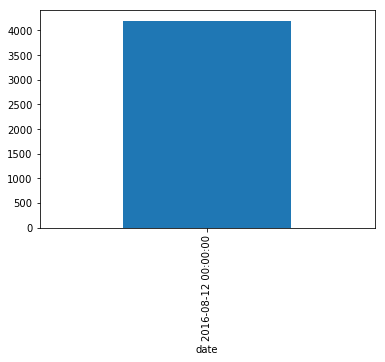

In [159]:
# Timeline of tweetcount

df_tweets = tweets.groupby(by='date', as_index=True)[['datetime']].count()
df_tweets.rename(columns = { 'datetime': 'tweet_count' }, inplace=True)

print(df_tweets.head())
df_tweets.plot(kind='bar', legend=False)
plt.show()

      tweet_count
hour             
12            312
13            845
14           1019
15           1113
16            912


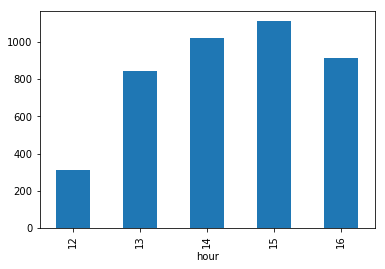

In [157]:
# Tweetcount by time of day

df_tweets = tweets.groupby(by='hour', as_index=True)[['datetime']].count()
df_tweets.rename(columns = { 'datetime': 'tweet_count' }, inplace=True)

print(df_tweets.head())
df_tweets.plot(kind='bar', legend=False)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


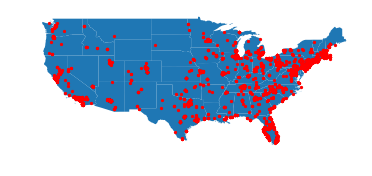

In [126]:
# Plotting tweets on map

# Generating GeoDataFrame with cities
# Only get tweets with coordinates and between bounding box. We are not interested in Alska, Hawaii and Guam.
df_cities = tweets[~tweets.lat.isnull()][(-130 < tweets.lon) & (tweets.lon < 0) & (20 < tweets.lat)]
geoms_cities = [Point(xy) for xy in zip(df_cities.lon, df_cities.lat)]
df_cities = df_cities.drop(['lat','lon'], axis=1)
crs = {'init' :'epsg:4269', 'no_defs': True}
cities = gpd.GeoDataFrame(df, crs = crs, geometry = geoms_cities)

# Plot world (without Alaska and Hawaii)
# TODO make multiple points more bright somehow
world_copy = world.copy()
world_copy = world_copy[(world_copy.STATE_NAME != 'Alaska') & (world_copy.STATE_NAME != 'Hawaii')]
base = world_copy.plot()
cities.plot(ax=base, marker='o', color='red', markersize=5);

plt.axis('off')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


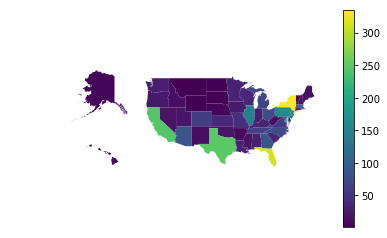

In [123]:
# Plotting tweetcount by state

# Group by state, Count(tweets)
df_tweets = tweets.groupby(by='state', as_index=False)[['datetime']].count()
df_tweets.rename(columns = { 'datetime': 'tweet_count' }, inplace=True)

# join population data with geo data
world_copy = world.copy()
world_copy = world_copy.merge(df_tweets, how='left', left_on='STATE_ABBR', right_on='state')

# changing the projection of reference system 
world_copy.crs = {'init' :'epsg:4269', 'no_defs': True}
world_copy = world_copy.to_crs({'init': 'epsg:3395'})

# transforming and scaling hawaii and alaska
world_copy.loc[world_copy.STATE_NAME == 'Alaska', 'geometry'] = world_copy[world_copy.STATE_NAME == 'Alaska']['geometry']\
    .scale(xfact=0.4, yfact=0.4)\
    .translate(xoff = 0.15e7, yoff = -0.35e7)
world_copy.loc[world_copy.STATE_NAME == 'Hawaii', 'geometry'] = world_copy[world_copy.STATE_NAME == 'Hawaii']['geometry']\
    .scale(xfact=2, yfact=2)\
    .translate(xoff = 0.2e7, yoff = 0.10e7)

# Color the states
world_copy.plot(column='tweet_count', legend=True)
plt.axis('off')
plt.show()